In [1]:
import pickle
import sys
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from torch.utils.data import DataLoader, Dataset

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [5]:
%load_ext autoreload
%autoreload 2

### Load data

In [6]:
data_training = pd.read_csv("../data/data-training.csv.gz")

In [7]:
rate_cols = [c for c in data_training.columns if "Rate" in c]
size_cols = [c for c in data_training.columns if "Size" in c]
other_cols = [c for c in data_training.columns if c not in rate_cols and c not in size_cols]
data_training = data_training[rate_cols + size_cols + other_cols]

In [8]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0       NaN       NaN       NaN       NaN   
1    1619.5    1620.0    1621.0    1621.5       NaN       NaN       NaN   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0       NaN       NaN       NaN        NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN        NaN        NaN        NaN        NaN   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   
1        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   
1    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0     1601.0     1600.0       1.0      10.0      24.0       NaN       NaN   
1     1601.0     1600.0       1.0      10.0      24.0       5.0       NaN   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
1       NaN       NaN       NaN       NaN       NaN        NaN        NaN   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        NaN        NaN        NaN       7.0      10.0       1.0      10.0   
1        NaN        NaN        NaN       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [9]:
data_training = python.utils.fix_input_df(data_training)

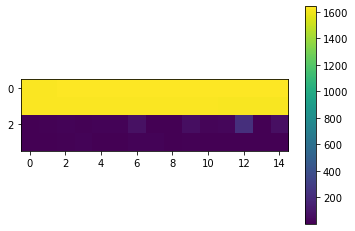

In [10]:
plt.imshow(data_training.drop("y", axis=1).iloc[100200].astype(np.float32).values.reshape(4, 15))
plt.colorbar()

In [11]:
data_training["midpointRate"] = (data_training["askRate0"] + data_training["bidRate0"]) / 2

In [12]:
df = data_training.copy()

ask_rate_cols = [c for c in df.columns if c.startswith("askRate")]
bid_rate_cols = [c for c in df.columns if c.startswith("bidRate")]
ask_size_cols = [c for c in df.columns if c.startswith("askSize")]
bid_size_cols = [c for c in df.columns if c.startswith("bidSize")]
other_diff_cols = ["midpointRate"]
other_cols = ["y"]

In [13]:
(df["midpointRate"].values[1:] == df["midpointRate"].values[:-1]).sum()

2744844

In [14]:
(df["y"] == 0).sum()

633418

In [15]:
df[bid_rate_cols] = (df[bid_rate_cols].values - df[ask_rate_cols].values)

In [16]:
df[bid_size_cols] = (df[bid_size_cols].values - df[ask_size_cols].values)

In [17]:
df[ask_rate_cols] = np.vstack(
    [
        np.zeros((1, len(ask_rate_cols))),
        (df[ask_rate_cols].values[1:, :] - df[ask_rate_cols].values[:-1, :]),
    ]
)

In [18]:
df[ask_size_cols] = np.vstack(
    [
        np.zeros((1, len(ask_rate_cols))),
        (df[ask_size_cols].values[1:, :] - df[ask_size_cols].values[:-1, :]),
    ]
)

In [19]:
df[other_diff_cols] = np.vstack(
    [
        np.zeros((1, len(other_diff_cols))),
        (df[other_diff_cols].values[1:, :] - df[other_diff_cols].values[:-1, :]),
    ]
)

In [20]:
data_training = df.iloc[1:]

In [21]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
1       0.0       0.0       0.0       0.5       0.5       0.5       0.5   
2       0.0       0.0       0.0       0.0       0.5       0.5       0.5   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
1       0.5       0.5       0.5        0.5        0.5        0.5        0.5   
2       0.5       0.5       0.5        0.5        0.5        0.5        0.5   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
1        0.5      -4.5      -6.0      -8.0      -9.5     -10.5     -11.5   
2        0.5      -4.5      -6.0      -8.0      -9.5     -11.0     -12.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
1     -14.5     -15.5     -16.5     -17.5      -18.5      -19.5      -20.0   
2     -15.0     -16.0     -17.0     -18.0      -19.0      -20.0      -20.5   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
1      -20.5      -21.5       0.0       0.0       0.0       5.0       0.0   
2      -21.0      -22.0       0.0       0.0       0.0       0.0       2.0   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
1       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
2       0.0       0.0       0.0       0.0       0.0        0.0        0.0   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
1        0.0        0.0        0.0       6.0       0.0     -23.0       5.0   
2        0.0        0.0        0.0       6.0       0.0     -23.0       5.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
2      18.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  midpointRate  
1       10.0        1.0       10.0       13.0 -0.5           0.0  
2       10.0        1.0       10.0       13.0 -0.5           0.0

2999998


In [22]:
TRAIN_TEST_SPLITS = []
for i in range(5):
    start = int(len(data_training) * 0.2 * i)
    stop = int(len(data_training) * 0.2 * (i + 1))

    train_df = pd.concat([data_training.iloc[:start], data_training.iloc[stop:]]).copy()
    valid_df = data_training.iloc[start:stop].copy()
    assert len(train_df) + len(valid_df) == len(data_training)
    assert not set(train_df.index) & set(valid_df.index)

    feature_columns = [c for c in train_df.columns if (c.startswith("askSize") or c.startswith("bid"))]
    assert len(feature_columns) == 45
    column_means = train_df[feature_columns].mean(axis=0).values.reshape(1, -1)
    column_ranges = (
        #
        train_df[feature_columns].max(axis=0).values.reshape(1, -1)
        - train_df[feature_columns].min(axis=0).values.reshape(1, -1)
    ) / 10

    train_df[feature_columns] = (
        train_df[feature_columns].values - column_means
    ) / column_ranges
    valid_df[feature_columns] = (
        valid_df[feature_columns].values - column_means
    ) / column_ranges

    all_cols = ask_size_cols + ask_rate_cols + bid_size_cols + bid_rate_cols + other_diff_cols + other_cols
    TRAIN_TEST_SPLITS.append((train_df[all_cols], valid_df[all_cols]))

In [23]:
train_df, valid_df = TRAIN_TEST_SPLITS[0]

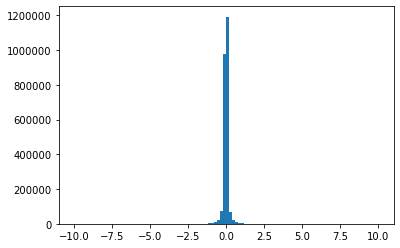

In [24]:
_ = plt.hist(train_df["bidSize0"], bins=100, range=(-10, 10))

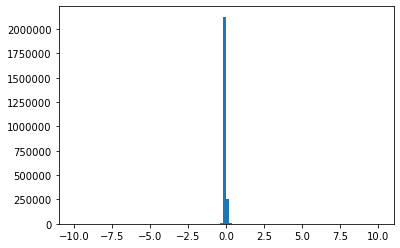

In [25]:
_ = plt.hist(train_df["askSize0"], bins=100, range=(-10, 10))

In [26]:
train_df.describe()

askSize0      askSize1      askSize2      askSize3      askSize4  \
count  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06   
mean  -2.978521e-19 -2.407942e-20  9.171776e-20  5.621085e-20  9.628037e-19   
std    6.268985e-02  7.799448e-02  8.622781e-02  9.399706e-02  8.792661e-02   
min   -4.985755e+00 -5.228216e+00 -5.000000e+00 -5.000000e+00 -5.000000e+00   
25%   -5.341883e-08 -5.763027e-09  1.653440e-08 -2.210434e-08  9.384388e-09   
50%   -5.341883e-08 -5.763027e-09  1.653440e-08 -2.210434e-08  9.384388e-09   
75%   -5.341883e-08 -5.763027e-09  1.653440e-08 -2.210434e-08  9.384388e-09   
max    5.014245e+00  4.771784e+00  5.000000e+00  5.000000e+00  5.000000e+00   

           askSize5      askSize6      askSize7      askSize8      askSize9  \
count  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06   
mean   6.964918e-20 -2.842158e-19  5.914542e-20 -1.648913e-19 -8.233984e-19   
std    9.512790e-02  1.093935e-01  1.029364e-01  8.881498e-02  8.854505e-02   
min   -5.000000e+00 -5.000000e+00 -5.000000e+00 -5.003779e+00 -5.000000e+00   
25%    1.371197e-07  2.627629e-08 -1.573515e-08 -5.039055e-08 -1.882531e-08   
50%    1.371197e-07  2.627629e-08 -1.573515e-08 -5.039055e-08 -1.882531e-08   
75%    1.371197e-07  2.627629e-08 -1.573515e-08 -5.039055e-08 -1.882531e-08   
max    5.000000e+00  5.000000e+00  5.000000e+00  4.996221e+00  5.000000e+00   

          askSize10     askSize11     askSize12     askSize13     askSize14  \
count  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06   
mean  -3.868782e-19 -9.247074e-19 -2.541949e-19  3.194148e-19 -5.138961e-19   
std    7.968534e-02  8.306163e-02  8.281031e-02  8.565923e-02  8.721704e-02   
min   -4.969880e+00 -5.000000e+00 -5.000000e+00 -4.996277e+00 -5.000000e+00   
25%   -9.412655e-09  3.100200e-09 -1.271082e-07 -1.861505e-08  1.241928e-08   
50%   -9.412655e-09  3.100200e-09 -1.271082e-07 -1.861505e-08  1.241928e-08   
75%   -9.412655e-09  3.100200e-09 -1.271082e-07 -1.861505e-08  1.241928e-08   
max    5.030120e+00  5.000000e+00  5.000000e+00  5.003723e+00  5.000000e+00   

           askRate0      askRate1      askRate2      askRate3      askRate4  \
count  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06   
mean  -2.083334e-05 -2.083334e-05 -2.083334e-05 -2.083334e-05 -2.083334e-05   
std    1.179663e-01  1.146971e-01  1.151684e-01  1.152516e-01  1.155945e-01   
min   -6.500000e+00 -5.500000e+00 -4.500000e+00 -4.000000e+00 -5.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    6.000000e+00  7.000000e+00  7.500000e+00  7.500000e+00  8.000000e+00   

           askRate5      askRate6      askRate7      askRate8      askRate9  \
count  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06   
mean  -2.083334e-05 -2.083334e-05 -2.083334e-05 -2.083334e-05 -2.083334e-05   
std    1.162335e-01  1.184123e-01  1.208288e-01  1.238683e-01  1.319367e-01   
min   -7.500000e+00 -7.500000e+00 -1.100000e+01 -1.400000e+01 -1.500000e+01   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    9.000000e+00  9.000000e+00  9.500000e+00  9.500000e+00  1.100000e+01   

          askRate10     askRate11     askRate12     askRate13     askRate14  \
count  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06  2.399999e+06   
mean  -2.083334e-05 -2.083334e-05 -2.083334e-05 -2.083334e-05 -2.062501e-05   
std    1.409522e-01  1.539596e-01  1.604298e-01  1.671209e-01  1.736151e-01   
min   -2.000000e+01 -2.100000e+01 -2.200000e+01 -2.300000e+01 -2.450000e+01   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.00000

In [27]:
assert (train_df.drop("y", axis=1).describe().loc["mean"].abs() < 1e-4).all()

In [28]:
assert (train_df.drop(pd.Index(["y"] + [c for c in train_df.columns if c.startswith("askRate")]), axis=1).max() <= 10).all()

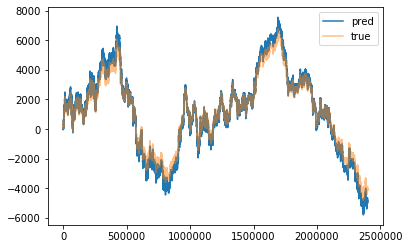

In [79]:
plt.plot(np.cumsum(train_df["askRate0"].values * 100), label="pred")
plt.plot(np.cumsum(train_df["y"].values), label="true", alpha=0.5)
plt.legend(loc="upper right")

In [77]:
stats.pearsonr(train_df["y"].values[:-1], train_df["midpointRate"].values[1:])

(0.10780719795751356, 0.0)